In [1]:
import torch
from torch.autograd import Variable
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4, P4MConvZ2, P4MConvP4M
import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
import numpy as np
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn
from torchsummary import summary
import time
import copy
import matplotlib.pyplot as plt
import os

from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze

/home/salavib/Projects/env_cv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/salavib/Projects/env_cv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/salavib/Projects/env_cv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/salavib/Projects/env_cv/lib/python3.6/site-packages/ten

In [2]:
data_transformation = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation([-10,10]),
        transforms.ToTensor(),
        transforms.Normalize(0,1)
    ]),
    'val':
    ToTensor()
}
train_ds = torchvision.datasets.FashionMNIST('dataset',download=True,train=True,
                                             transform=data_transformation['train'])
test_ds = torchvision.datasets.FashionMNIST('dataset',download=True,train=False,
                                            transform=data_transformation['val'])

In [3]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='2,3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
img_datasets = {'train':train_ds, 'val':test_ds}
dataset_sizes = {x: len(img_datasets[x]) for x in ['train', 'val']}

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv2d = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.p4convz2 = P4ConvZ2(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.linear = nn.Linear(128, 10)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14*14*320, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x1 = self.conv2d(x)
        x2 = self.p4convz2(x)
        x2 = x2.view(x2.shape[0],x2.shape[1]*x2.shape[2], x2.shape[3],x2.shape[4])
#         print(x2.shape)
#         print(x1.shape)
        x = torch.cat((x1,x2),1)
#         print(x.shape)
        x = torch.flatten(x,1)
#         print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        channel_size = [64,32,16,8,16,32,64]
        strides = [1,1,2,1,1,1,1]
        kernels = [7,7,7,7,7,7,7]
        self.conv2d = nn.ModuleList()
        self.p4convz2 = nn.ModuleList()
        self.p4mconvz2 = nn.ModuleList()
        self.n_layers = len(channel_size)    
        
        for layer in range(len(channel_size)):
            oc = channel_size[layer]
            s = strides[layer]
            k = kernels[layer]
            p = int(k//2)
            if layer == 0:
                self.conv2d.extend([nn.Conv2d(1, oc, kernel_size=(k, k), stride=(s, s), padding=(p, p), bias=False)]) 
                self.p4convz2.extend([P4ConvZ2(in_channels=1, out_channels=oc, kernel_size=k, stride=s, padding=p)])
                self.p4mconvz2.extend([P4MConvZ2(in_channels=1, out_channels=oc, kernel_size=k, stride=s, padding=p)])
            else:
                ic = channel_size[layer-1]*13
                self.conv2d.extend([nn.Conv2d(ic, oc, kernel_size=(k, k), stride=(s, s), padding=(p, p), bias=False)])
                self.p4convz2.extend([P4ConvZ2(in_channels=ic, out_channels=oc, kernel_size=k, stride=s, padding=p)])
                self.p4mconvz2.extend([P4MConvZ2(in_channels=ic, out_channels=oc, kernel_size=k, stride=s, padding=p)])
                
                
        self.relu = nn.ReLU()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14*14*channel_size[-1]*13, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        
        for layer in range(self.n_layers):
            x1 = self.conv2d[layer](x)
            x2 = self.p4convz2[layer](x)
            x3= self.p4mconvz2[layer](x)
            x2 = x2.view(x2.shape[0],x2.shape[1]*x2.shape[2], x2.shape[3],x2.shape[4])
            x3 = x3.view(x3.shape[0],x3.shape[1]*x3.shape[2], x3.shape[3],x3.shape[4])
            x = torch.cat((x1,x2,x3),1)
            x = self.relu(x)

        x = torch.flatten(x,1)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork()
# summary(model, (1,28,28))

In [8]:
model = nn.DataParallel(model, device_ids=[0,1])
model = model.to(device)

In [9]:
torch.cuda.current_device()

0

In [10]:
dataloaders = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=200, shuffle=True, num_workers=4) for x in ['train','val']}

In [11]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)#, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

scheduler =exp_lr_scheduler
optimizer=optimizer_ft

In [ ]:
num_epochs=30

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
losses = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                losses.append(loss)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            pass
#             scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/29
----------


In [ ]:
torch.save(model.state_dict(), 'temp/model_g_2')

In [ ]:
import numpy as np

losses_ar = np.asarray([x.cpu().detach().numpy() for x in losses])
with open('temp/losses_2.npy', 'wb') as f:
    np.save(f, losses_ar)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


In [ ]:
model_ft = models.resnet18(pretrained=True)

In [42]:
losses_ar = np.asarray([x.cpu().detach().numpy() for x in losses])

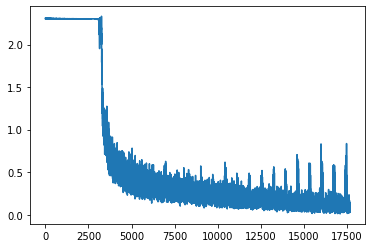

In [43]:
plt.plot(losses_ar)
plt.show()

In [16]:
def train(model, dataloaders,criterion,optimizer,scheduler,num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    losses.append(loss)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                pass
    #             scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    losses_ar = np.asarray([x.cpu().detach().numpy() for x in losses])
    return model,losses_ar

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv2d = nn.Conv2d(1, 64*5, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         self.p4convz2 = P4ConvZ2(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.linear = nn.Linear(128, 10)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14*14*320, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv2d(x)
#         x2 = self.p4convz2(x)
#         x2 = x2.view(x2.shape[0],x2.shape[1]*x2.shape[2], x2.shape[3],x2.shape[4])
#         print(x2.shape)
#         print(x1.shape)
#         x = torch.cat((x1,x2),1)
#         print(x.shape)
        x = torch.flatten(x,1)
#         print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits

In [18]:
model_cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_cnn, losses_2 = train(model_cnn, dataloaders,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=4)

Epoch 0/3
----------
train Loss: 2.3044 Acc: 0.0977
val Loss: 2.3045 Acc: 0.0957

Epoch 1/3
----------
train Loss: 2.3044 Acc: 0.0977
val Loss: 2.3045 Acc: 0.0957

Epoch 2/3
----------
train Loss: 2.3044 Acc: 0.0977
val Loss: 2.3045 Acc: 0.0957

Epoch 3/3
----------
train Loss: 2.3044 Acc: 0.0977
val Loss: 2.3045 Acc: 0.0957

Training complete in 6m 20s
Best val Acc: 0.095700


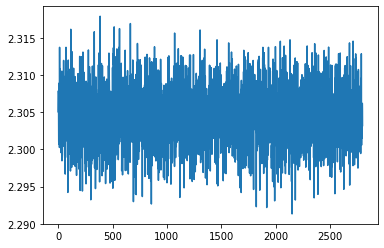

In [19]:
plt.plot(losses_2)
plt.show()

In [20]:
for parameter in model.parameters():
    print(parameter.shape)

torch.Size([64, 1, 7, 7])
torch.Size([64, 1, 1, 7, 7])
torch.Size([64])
torch.Size([10, 128])
torch.Size([10])
torch.Size([1024, 62720])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [21]:
for parameter in model_cnn.parameters():
    print(parameter.shape)

torch.Size([320, 1, 7, 7])
torch.Size([10, 128])
torch.Size([10])
torch.Size([1024, 62720])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [22]:
from mftma.manifold_analysis_correlation import manifold_analysis_corr

X = [np.random.randn(5000, 50) for i in range(100)] # Replace this with data to analyze
kappa = 0
n_t = 200

capacity_all, radius_all, dimension_all, center_correlation, K = manifold_analysis_corr(X, kappa, n_t)

avg_capacity = 1/np.mean(1/capacity_all)
avg_radius = np.mean(radius_all)
avg_dimension = np.mean(dimension_all)



Instructions for updating:
non-resource variables are not supported in the long term


In [43]:
model_cnn = model_cnn.eval()

sampled_classes = 10
examples_per_class = 100

datas = make_manifold_data(train_ds, sampled_classes, examples_per_class, seed=0)
datas = [d.to(device) for d in data]

In [41]:
for name, layer in model.named_modules():
    print(name, layer)

 NeuralNetwork(
  (conv2d): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (p4convz2): P4ConvZ2()
  (linear): Linear(in_features=128, out_features=10, bias=True)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=62720, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
conv2d Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
p4convz2 P4ConvZ2()
linear Linear(in_features=128, out_features=10, bias=True)
linear_relu_stack Sequential(
  (0): Linear(in_features=62720, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=10, bias=True)
)
linear_relu_stack.0 Linear(in_features=62720, out_features=1024, bias=True)
linear_relu_stack.1 ReLU()
linear_relu_stack.2 Linear(in_featu

In [45]:
activations = extractor(model_cnn, datas, layer_types=['Conv2d', 'Linear','P4ConvZ2'])
list(activations.keys())



['layer_0_Input',
 'layer_1_Conv2d',
 'layer_3_Linear',
 'layer_5_Linear',
 'layer_7_Linear']

In [34]:
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

Projecting layer_1_Conv2d


In [35]:


capacities = []
radii = []
dimensions = []
correlations = []

for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
    
    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)



layer_0_Input capacity: 0.104934, radius 0.963711, dimension 18.989687, correlation 0.431222
layer_1_Conv2d capacity: 0.082099, radius 0.998654, dimension 22.507182, correlation 0.422936
layer_3_Linear capacity: 0.103322, radius 0.957381, dimension 19.320024, correlation 0.423591
layer_5_Linear capacity: 0.055898, radius 1.424833, dimension 26.685652, correlation 0.427329
layer_7_Linear capacity: 0.198392, radius 28418.985901, dimension 5.477545, correlation 0.421630


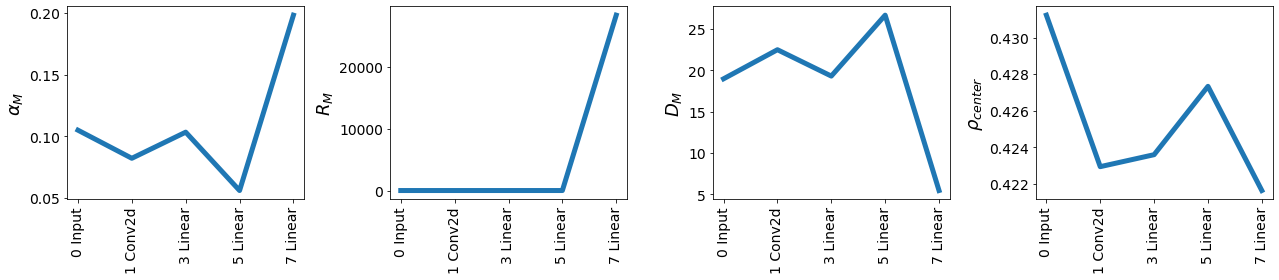

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

In [46]:
activations = extractor(model, datas, layer_types=['Conv2d', 'Linear','P4ConvZ2'])
list(activations.keys())

for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X
    
capacities = []
radii = []
dimensions = []
correlations = []

for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
    
    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)
    
    


Projecting layer_1_Conv2d
Projecting layer_2_P4ConvZ2
layer_0_Input capacity: 0.104934, radius 0.963711, dimension 18.989687, correlation 0.431222
layer_1_Conv2d capacity: 0.034178, radius 5.560515, dimension 37.889648, correlation 0.474158
layer_2_P4ConvZ2 capacity: 0.035506, radius 6.183361, dimension 35.480839, correlation 0.487845
layer_4_Linear capacity: 0.063783, radius 1.696841, dimension 19.379703, correlation 0.525228
layer_6_Linear capacity: 0.073907, radius 2.104890, dimension 15.433720, correlation 0.562791
layer_8_Linear capacity: 0.330972, radius 5.688531, dimension 4.035815, correlation 0.655676


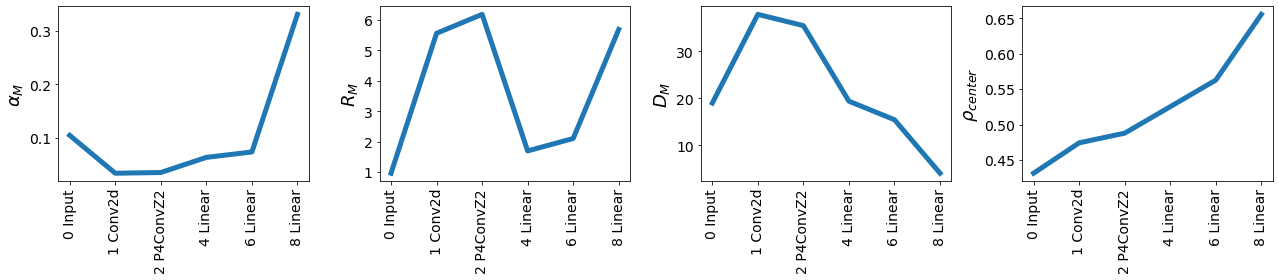

In [47]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

In [ ]:
print(torch.cuda.current_device() )
print(torch.cuda.get_device_name(0))
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())
gpu_n=0
t = torch.cuda.get_device_properties(gpu_n).total_memory
r = torch.cuda.memory_reserved(gpu_n)
a = torch.cuda.memory_allocated(gpu_n)
f = r-a  # free inside reserved
print(f'Reserved {r/2**20}')
print(f'Allocated {a/2**20}')
print(f'Free {f/2**20}')